# 2D stabilized Darcy Problem

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_darcy2D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_darcy2D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/darcy2D.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

Darcy equation is a second-order, elliptic PDE (partial differential equation), which describes the flow through a porous medium at low speed. It is widely used in hydraulic engineering and petroleum engineering. The Darcy equation was originally formulated by Henry Darcy on the basis of experimental results of permeability experiments in sandy soil, and later derived from the Navier-Stokes equation by Stephen Whitaker via the homogenization method.

It is difficult to obtain a generalized analytical solution of the Darcy equation for the permeability field of different fluids and the numerical method is usually used to solve the Darcy governing equation describing a specific scenario, and then the pressure field and velocity field of flow under the scenario are simulated. The numerical simulation results of Darcy flow can be used for further scientific research and engineering practice. Finite element method (FEM) for Darcy equation is designed to work with finite element spaces. In addition, for many problems of practical interest, some physical terms of the Darcy equation will be stabilized. The finite element method is designed in the standard finite element grid space. The higher accuracy required for numerical solution, the more fine the grid needs to be divided, and it costs larger time and storage overhead.

As the research of parallel algorithm for numerical solution tends to slow down, the method based on neural network has been developed and achieved the solution accuracy close to the traditional numerical method. In 2019, the Applied Mathematics team of Brown University proposed a Physics-informed Neural Networks (PINNs) and provided a complete code framework to construct PINNs for solving a wide variety of PDEs. In this case, MindSpore Flow suite of fluid equations is used to solve the two-dimensional stabilized Darcy equation based on PINNs method.

## Problem Description

Considering the two-dimensional cube $\Omega=(0, 1)\times(0, 1)$, The boundary of the cube is $\Gamma$. Ignoring the effects of gravity, in the range of $\Omega$, the two-dimensional stabilized Darcy equation satisfied by the fluid pressure $p$ and velocity $u$ is as follows:

$$
\begin{align}
u + \nabla p &= 0, (x, y)\in\Omega\\
\nabla \cdot u &= f, (x, y)\in\Omega
\end{align}
$$

The Dirichlet boundary conditions are used in this case in the following form:

$$
\begin{align}
u_x &= -2 \pi cos(2 \pi x) cos(2 \pi y) &(x, y)\in\Gamma\\
u_y &= 2 \pi sin(2 \pi x) sin(2 \pi y) &(x, y)\in\Gamma\\
p &= sin(2 \pi x) cos(2 \pi y) &(x, y)\in\Gamma
\end{align}
$$

In which $f$ is **forcing function** in the Darcy equation. In this case, **forcing function** $f$ is used to learn the mapping $(x, y) \mapsto (u, p)$ from position to corresponding physical quantities when **forcing function** $f$ is $8 \pi^2 sin(2 \pi x)cos(2 \pi y)$. So that the solution of Darcy equation is realized.

## Technology Path

MindSpore Flow solves 2D constant Darcy problem is as follows:

1. Dataset Construction.

2. Model Construction.

3. Optimizer.

4. 2D Darcy.

5. Model Training.

6. Model Evaluation and Visualizetion.

In [1]:
import time

import numpy as np
import mindspore as ms

from mindspore import nn, Tensor, ops, jit, set_seed, data_sink
from mindspore import dtype as mstype
from sympy import Function, symbols, sin, cos, pi

The following `src` pacakage can be downloaded in [applications/physics_driven/darcy/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/darcy/src).

In [2]:
from mindflow.utils import load_yaml_config
from mindflow.cell import FCSequential
from mindflow.pde import PDEWithLoss, sympy_to_mindspore


from src import create_training_dataset, create_test_dataset
from src import calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config("darcy_cfg.yaml")
ms.set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = ms.get_context(attr_key='device_target') == "Ascend"

### Dataset Construction

For the training dataset, this case conducts random sampling according to the problem domain and boundary conditions. The sampling configuration information is as follows, and samples are collected according to uniform distribution. The problem domain of cube is constructed, and then the known problem domain and boundary are sampled.


In [5]:
# create train dataset
geom_name = "flow_region"
flow_train_dataset = create_training_dataset(config, geom_name)
train_data = flow_train_dataset.create_dataset(
    batch_size=config["train_batch_size"], shuffle=True, drop_remainder=True
)

# create test dataset
test_input, test_label = create_test_dataset(config)

### Model Construction

This example uses a neural network structure with 6 layers and 128 neurons per layer, which contains 6 fully-connected layers and 5 residual layers, and the activation function is a tanh function. The residual layers effectively keep the gradient from vanishing in each passing layer, making deeper network structures possible.

In [6]:
# network model
model = FCSequential(in_channels=config["model"]["input_size"],
                     out_channels=config["model"]["output_size"],
                     neurons=config["model"]["neurons"],
                     layers=config["model"]["layers"],
                     residual=config["model"]["residual"],
                     act=config["model"]["activation"],
                     weight_init=config["model"]["weight_init"])

## Optimizer

In [7]:
# optimizer
params = model.trainable_params()
optim = nn.Adam(params, learning_rate=config["optimizer"]["lr"])

## 2D Darcy

The following Darcy2D defines the Darcy' problem. Specifically, it includes 2 parts: governing equation and boundary conditions.

In [8]:
class Darcy2D(PDEWithLoss):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        self.x, self.y = symbols("x y")
        self.u = Function("u")(self.x, self.y)
        self.v = Function("v")(self.x, self.y)
        self.p = Function("p")(self.x, self.y)
        self.in_vars = [self.x, self.y]
        self.out_vars = [self.u, self.v, self.p]
        self.loss_fn = loss_fn
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)
        super(Darcy2D, self).__init__(model, self.in_vars, self.out_vars)

    def force_function(self, x, y):
        return 8 * pi**2 * sin(2 * pi * x) * cos(2 * pi * y)

    def pde(self):
        loss_1 = (
            self.u.diff(self.x)
            + self.v.diff(self.y)
            - self.force_function(self.x, self.y)
        )
        loss_2 = self.u + self.p.diff(self.x)
        loss_3 = self.v + self.p.diff(self.y)
        return {"loss_1": loss_1, "loss_2": loss_2, "loss_3": loss_3}

    def bc(self):
        u_boundary = self.u - (-2 * pi * cos(2 * pi * self.x) * cos(2 * pi * self.y))

        v_boundary = self.v - (2 * pi * sin(2 * pi * self.x) * sin(2 * pi * self.y))

        p_boundary = self.p - (sin(2 * pi * self.x) * cos(2 * pi * self.y))

        return {
            "u_boundary": u_boundary,
            "v_boundary": v_boundary,
            "p_boundary": p_boundary,
        }

    def get_loss(self, pde_data, bc_data):
        pde_res = ops.Concat(1)(self.parse_node(self.pde_nodes, inputs=pde_data))
        pde_loss = self.loss_fn(
            pde_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        bc_res = ops.Concat(1)(self.parse_node(self.bc_nodes, inputs=bc_data))
        bc_loss = self.loss_fn(
            bc_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        return pde_loss + bc_loss

## Model Training

With MindSpore version >= 2.0.0, we can use the functional programming for training neural networks.

In [9]:
def train():
    # define problem
    problem = Darcy2D(model)

    def forward_fn(pde_data, bc_data):
        return problem.get_loss(pde_data, bc_data)

    grad_fn = ms.value_and_grad(forward_fn, None, optim.parameters, has_aux=False)

    @jit
    def train_step(pde_data, bc_data):
        loss, grads = grad_fn(pde_data, bc_data)
        loss = ops.depend(loss, optim(grads))
        return loss

    epochs = config["train_epoch"]
    steps_per_epochs = train_data.get_dataset_size()
    sink_process = data_sink(train_step, train_data, sink_size=1)

    for epoch in range(1, 1 + epochs):
        local_time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            cur_loss = sink_process()
        print(f"epoch: {epoch} train loss: {cur_loss} epoch time: {(time.time() - local_time_beg) * 1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, test_input, test_label, config["train_batch_size"])

In [10]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

u_boundary: u(x, y) + 2*pi*cos(2*pi*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 2
v_boundary: v(x, y) - 2*pi*sin(2*pi*x)*sin(2*pi*y)
    Item numbers of current derivative formula nodes: 2
p_boundary: p(x, y) - sin(2*pi*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 2
loss_1: -8*pi**2*sin(2*pi*x)*cos(2*pi*y) + Derivative(u(x, y), x) + Derivative(v(x, y), y)
    Item numbers of current derivative formula nodes: 3
loss_2: u(x, y) + Derivative(p(x, y), x)
    Item numbers of current derivative formula nodes: 2
loss_3: v(x, y) + Derivative(p(x, y), y)
    Item numbers of current derivative formula nodes: 2


epoch: 100 train loss: 6.8784714 epoch time: 1523.571 ms
    predict total time: 534.3403816223145 ms
    l2_error:  0.5755849074109586
epoch: 200 train loss: 0.6278709 epoch time: 1471.620 ms
    predict total time: 145.03049850463867 ms
    l2_error:  0.045125807781619925
...
epoch: 3800 train loss: 0.0044780443 epoch time: 1648.896 ms
    predict total time: 624.0160465240479 ms
    l2_error:  0.006336488966235181
epoch: 3900 train loss: 0.010450709 epoch time: 1453.108 ms
    predict total time: 3.2355785369873047 ms
    l2_error:  0.007389579493622406
epoch: 4000 train loss: 0.023211665 epoch time: 1587.883 ms
    predict total time: 293.90811920166016 ms
    l2_error:  0.008666194314787058
End-to-End total time: 6409.854037761688 s


### Model Evaluation and Visualizetion

After training, all data points in the flow field can be inferred. And related results can be visualized.

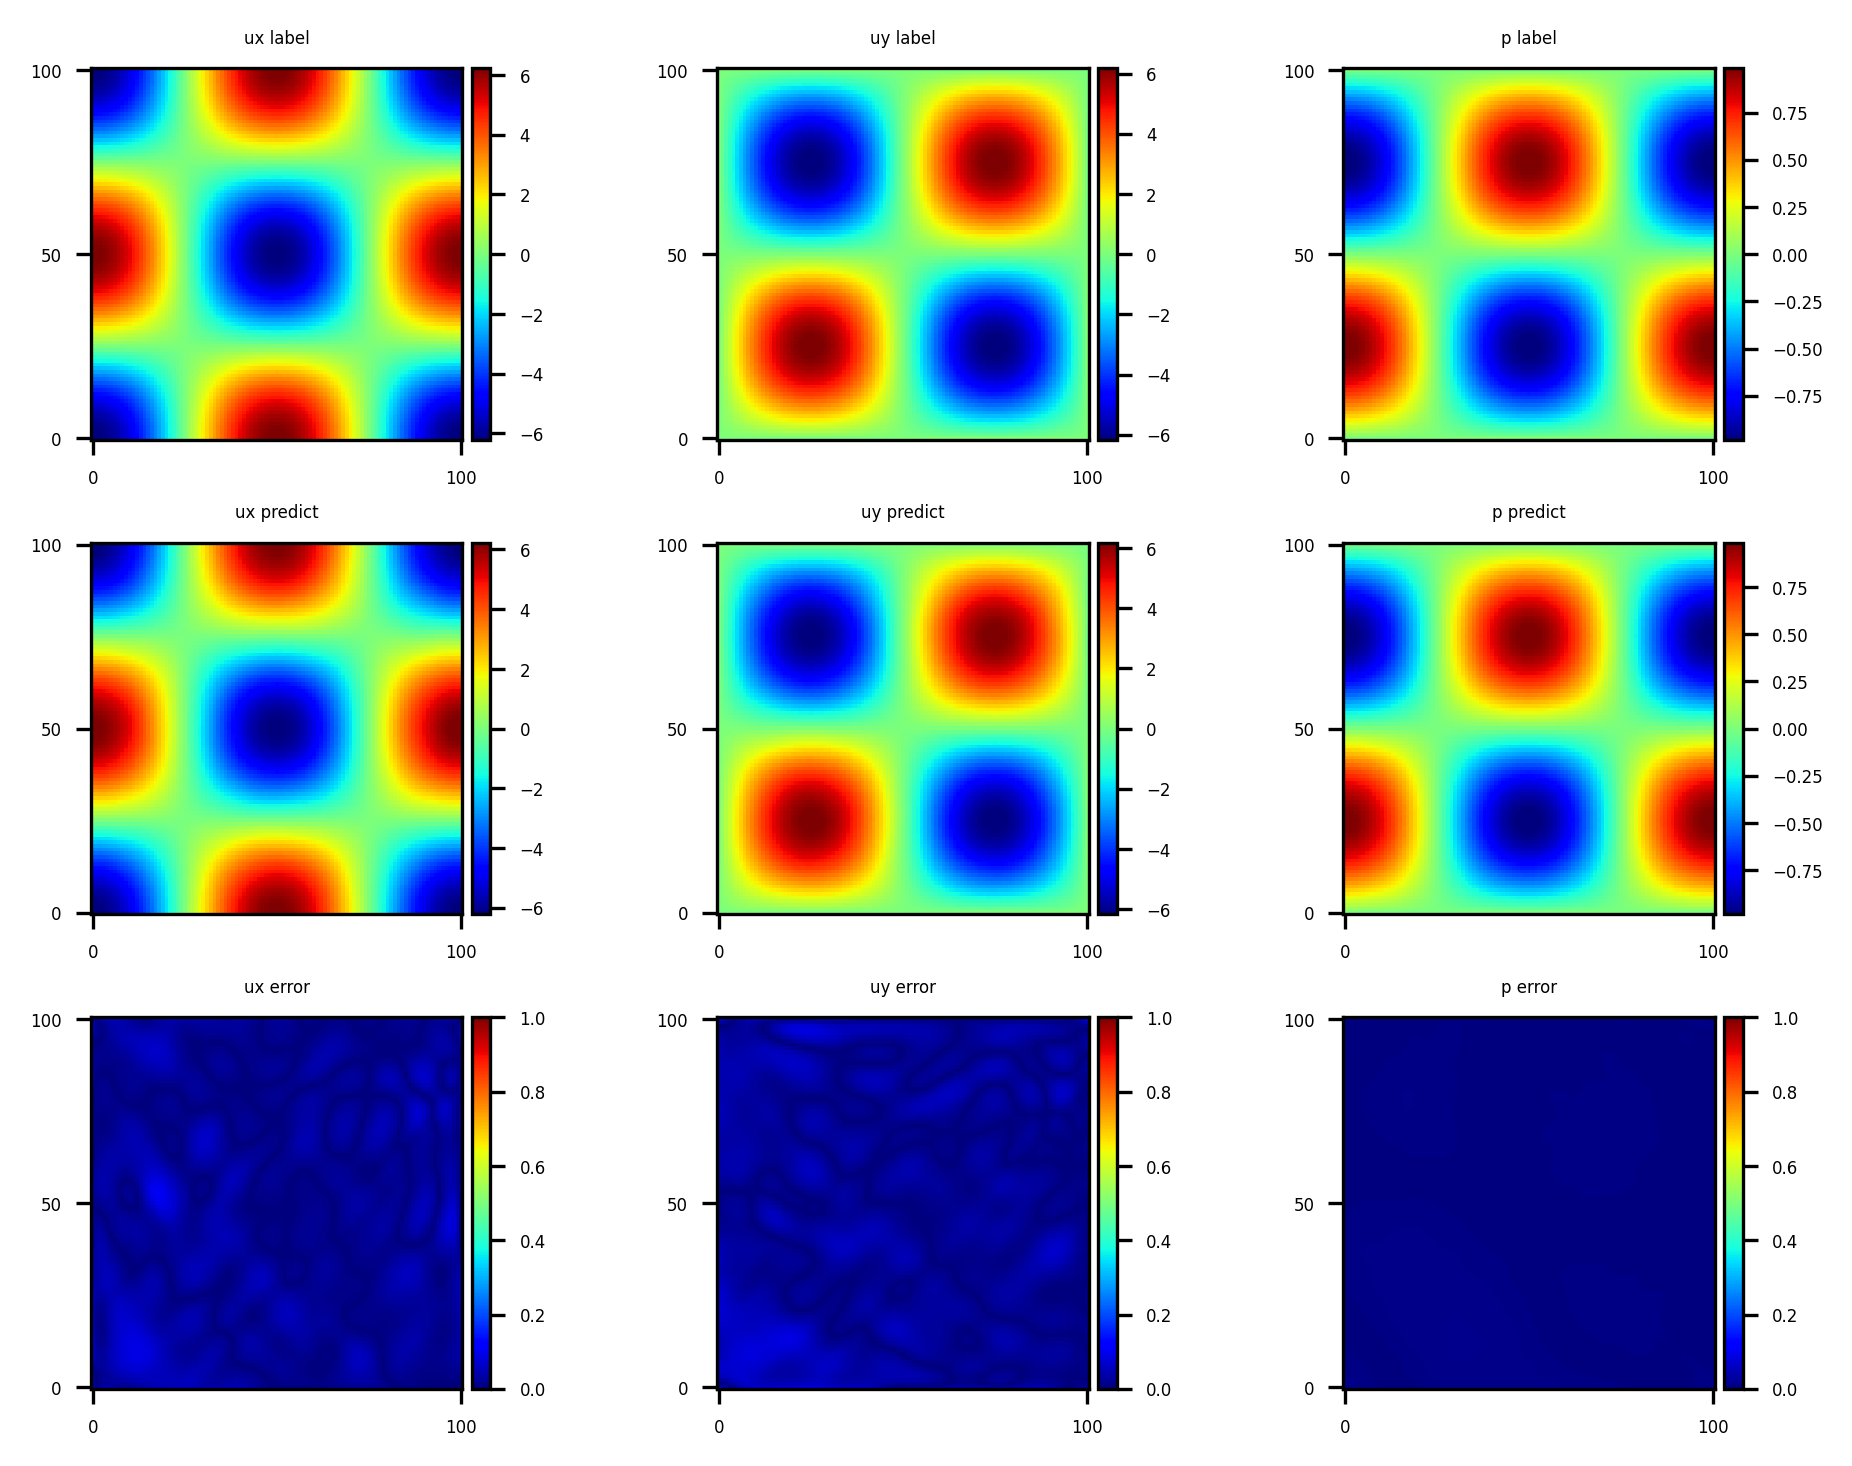

In [11]:
from src import visual
visual(model, config)